## Data analysis

In this last part, we attempt to find the correlation between topics and sentiments to see if there are anything that we can learn from the combination of both.

In [1]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import matplotlib.patches as patches
from matplotlib import transforms
from scipy.stats import chi2_contingency
from gensim.models import LdaModel

%matplotlib inline

X:\Programming\Anaconda\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


First, we read the data frame from BG_lda_pickle file.

In [2]:
BG_lda = pd.read_pickle('BG_lda_pickle')

From the classification.ipynb file, a matter that we can investigate is the emergence of certain time periods such as '2 week', '30 minute', '5 day' etc. What do these numbers mean? For example, what do the days and minutes refer to. Let's dive a little further to understand their meanings.

In [3]:
# list of time periods that exist from the word cloud in classification.ipynb
time_list = ['2_week', '5_day', '30_minute', '5_year']

# function to select examples of reviews with these periods (randomly selected from those with length 500 and below)
def find_periods(df, period):
    temp_df = df[df['tokens'].apply(lambda x: period in x)]
    temp_df = temp_df[temp_df['reviews'].str.len() < 500]
    temp_df = temp_df.sample(n=1)
    ind = int(temp_df['reviews'].index.values.astype(int))
    print(period+':')
    print(df['reviews'][ind].strip())
    print('')

for time in time_list:
    find_periods(BG_lda, time)

2_week:
I raised a complaint 2 weeks ago over the telephone and I have not had a call or a letter about it, disgraceful!!!!!

5_day:
I have two young children (5 & 11), boiler as completely packed in (got no hot water or heating), it's -5 (snowing) and I've been told nobody can come out until Monday (It's Thursday at the time of writing this review). So 5 days without heating or hot water?! It's an absolute disgrace! I am fuming. What are we paying for?! It's just unacceptable. Surely they can't expect people to sit in freezing cold houses with kids and vulnerable people for 5 days.

30_minute:
Apalling lack of customer care due to understaffing. We tried all day today to get them to cancel our Home Care agreement and did not succeed to get through. Call delay times were quoted as 20 - 30 minutes so they called back over an hour later when we ere out! Live chat saying 1 minute not responded all day. Complete shambles.

5_year:
After over 5 years with British Gas I have decided to switc

It does seem that the numbers have certain meaning behind each of them. 'Weeks' and 'Days' usually refer to how long a person has to wait before expecting a return call, an appointment or an engineer visit. '30 minutes' are always referring to the time spent waiting for the customer service to answer the call. '5 years' seems to be the length of how long the frustrated customers have been with British Gas.

Next, let's try to see if sentiment and topic are dependent of each other. We test our hypothesis below with alpha level at 0.05.

* Our null hypothesis is sentiment and topic are independent.
* Our alternative hypothesis is sentiment and topic are dependent.

We first create a contingency table of the two variables.

In [4]:
# creating cross tab between topic and sentiment
topic_sent = pd.crosstab(BG_lda['topic'], BG_lda['sentiment'], margins=True)
topic_sent.columns = ['Negative', 'Positive', 'row_totals']
topic_sent.index = ["1. Engineer Service",
                    "2. Plumbing Service",
                    "3. Account",
                    "4. General Perspective",
                    "5. Engineer Service",
                    "6. Boilers and Radiators",
                    "7. Customer Service",
                    "8. Installation Service",
                    "col_totals"]
topic_sent

,Negative,Positive,row_totals
1. Engineer Service,223,730,953
2. Plumbing Service,182,204,386
3. Account,162,54,216
4. General Perspective,49,183,232
5. Engineer Service,54,126,180
6. Boilers and Radiators,186,352,538
7. Customer Service,474,55,529
8. Installation Service,364,121,485
col_totals,1694,1825,3519


We calculate the chi-square statistic based on the formula: chi-square = sum((observed - expected)² / expected)

In [5]:
# our observed value is the actual count of each category based on the cross tab
observed = topic_sent.iloc[0:8,0:2]

# our expected value is the expected count based on the distribution of each category
expected = np.outer(topic_sent["row_totals"][0:8],
                     topic_sent.loc["col_totals"][0:2]) / 3519
expected = pd.DataFrame(expected)
expected.columns = ['Negative', 'Positive']
expected.index = ["1. Engineer Service",
                    "2. Plumbing Service",
                    "3. Account",
                    "4. General Perspective",
                    "5. Engineer Service",
                    "6. Boilers and Radiators",
                    "7. Customer Service",
                    "8. Installation Service",]

expected

,Negative,Positive
1. Engineer Service,458.761580,494.238420
2. Plumbing Service,185.815288,200.184712
3. Account,103.979540,112.020460
4. General Perspective,111.681728,120.318272
5. Engineer Service,86.649616,93.350384
6. Boilers and Radiators,258.986076,279.013924
7. Customer Service,254.653595,274.346405
8. Installation Service,233.472577,251.527423


In [6]:
# calculating the chi-square statistic
chi_square = (((observed-expected)**2)/expected).sum().sum()
chi_square

932.4352677071665

Even without refering to the critical value, we know that the p-value is less than 0.001. Given that our alpha level is 0.05, we reject the null hypothesis and conclude that sentiment and topic are dependent and correlated. Alternatively, we can use scipy's chi2_contingency to get the chi-square statistic, p-value, degree of freedom and expected values.

In [7]:
# returns chi-square, p-value, dof, expected values
chi2_contingency(observed)

(932.4352677071665,
 4.747662518793395e-197,
 7,
 array([[458.76157999, 494.23842001],
        [185.81528843, 200.18471157],
        [103.97953964, 112.02046036],
        [111.68172776, 120.31827224],
        [ 86.64961637,  93.35038363],
        [258.98607559, 279.01392441],
        [254.65359477, 274.34640523],
        [233.47257744, 251.52742256]]))

Since the two variables are correlated, let's visualise each topic segregated by sentiment to see the distribution of sentiments across the topics.

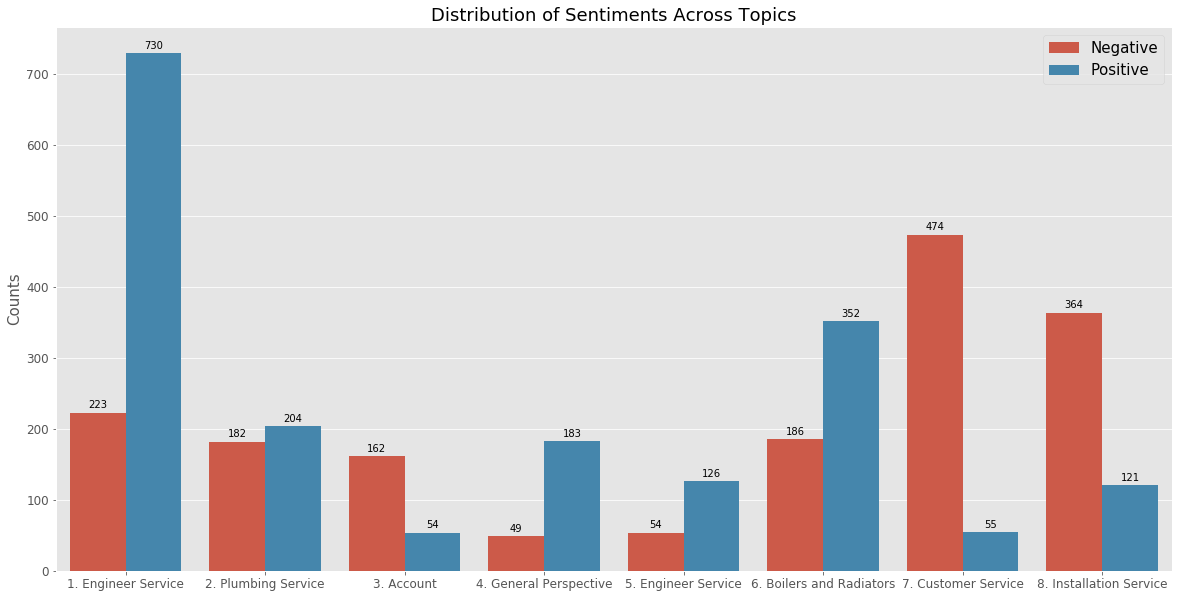

In [8]:
# plotting sentiment counts across topics
style.use('ggplot')
fig = plt.figure(figsize=(20, 10))

topic_sent_vis = observed.stack().reset_index().rename(columns={'level_0':'topic', 'level_1':'sentiment', 0:'value'})
ax = sns.barplot(x=topic_sent_vis['topic'], y=topic_sent_vis['value'], hue=topic_sent_vis['sentiment'], palette=["C0", "C1"])

ax.set_xlabel('')
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("Distribution of Sentiments Across Topics", fontsize=18)
ax.legend(prop=dict(size=15))
ax.tick_params(axis='x', which='major', labelsize = 12)
ax.tick_params(axis='y', which='major', labelsize = 12)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 6,
            '{:1.0f}'.format(height),
            ha="center") 
    
plt.show()

As expected from our pyLDAvis figure, it does seem that topics 1 and 5 are dominated by positive sentiment. On the other hand, topics 7 and 3 has significantly more negative sentiments as compared to positive ones. The rest of the topics which lie within the middle of the intertopic distance plot seems to have a mixture of both sentiments dominating. For example, topic 8 is dominant with negative reviews while topic 6 is the opposite. Since they overlap each another, we can also say that the ideas between the two topics are very much similar.

If we remember back when we scraped the data set from the website https://uk.trustpilot.com/review/www.britishgas.co.uk, the overall rating that was given was 2 out of 5 stars (currently 1 out of 5). However, if we look at the sentiment counts, there are more positive reviews than negative ones, albeit the numbers are really close. We suspect that the overall rating given by trustpilot has a recency weight attached to it whereby newer reviews carry a heavier weight in determining the overall rating.

Let us see if it is indeed the case that there are more negative reviews in recent times as compared to before.

In [9]:
# positive sentiments count is greater than negative ones
BG_lda['sentiment'].value_counts()

Positive    1825
Negative    1694
Name: sentiment, dtype: int64

In [10]:
# rearranging date format to change into quarter-year format
BG_lda['date'] = pd.to_datetime(BG_lda['date'], format = '%d/%m/%Y')
y = pd.to_numeric(BG_lda['date'].dt.year)
BG_lda['fy'] = np.where(BG_lda['date'].dt.month >= 4, y, y-1)
BG_lda['quarter'] = pd.PeriodIndex(BG_lda['date'], freq='Q-MAR').strftime('Q%q')
BG_lda['period'] = BG_lda['fy'].map(str) + BG_lda['quarter']
BG_lda.head()

,rating,reviews,date,sentiment,tokens,prob of topic #,topic,fy,quarter,period
0,1,Hive engineer failed to show twice...,2018-07-09,Negative,"[hive, engineer, fail, show, twice, take, two,...",0.982816,6. Boilers and Radiators,2018,Q2,2018Q2
1,1,I moved from SSE to British Gas be...,2018-07-09,Negative,"[move, sse, british_gas, sse, useless, get, sm...",0.769613,5. Engineer Service,2018,Q2,2018Q2
2,1,There engineers were rude and sur...,2018-07-09,Negative,"[engineer, rude, surely.3, time, get, back, jo...",0.969469,1. Engineer Service,2018,Q2,2018Q2
3,1,Firstly the App never works and th...,2018-07-06,Negative,"[firstly, app, never, work, people, ring, help...",0.652769,2. Plumbing Service,2018,Q2,2018Q2
4,1,Conned me left right and centre. B...,2018-07-05,Negative,"[con, leave, right, centre, 14, year, soon, te...",0.607794,3. Account,2018,Q2,2018Q2


First, let's see the distribution of sentiments across the year without taking into account the topics.

In [11]:
# stack the variables to produce the plot
sent_year = pd.crosstab(BG_lda['sentiment'], BG_lda['period'])
sent_year = sent_year.stack().reset_index().rename(columns={0:'value'})
sent_year = sent_year[sent_year['period'] != '2018Q2'] # remove Q2 of 2018

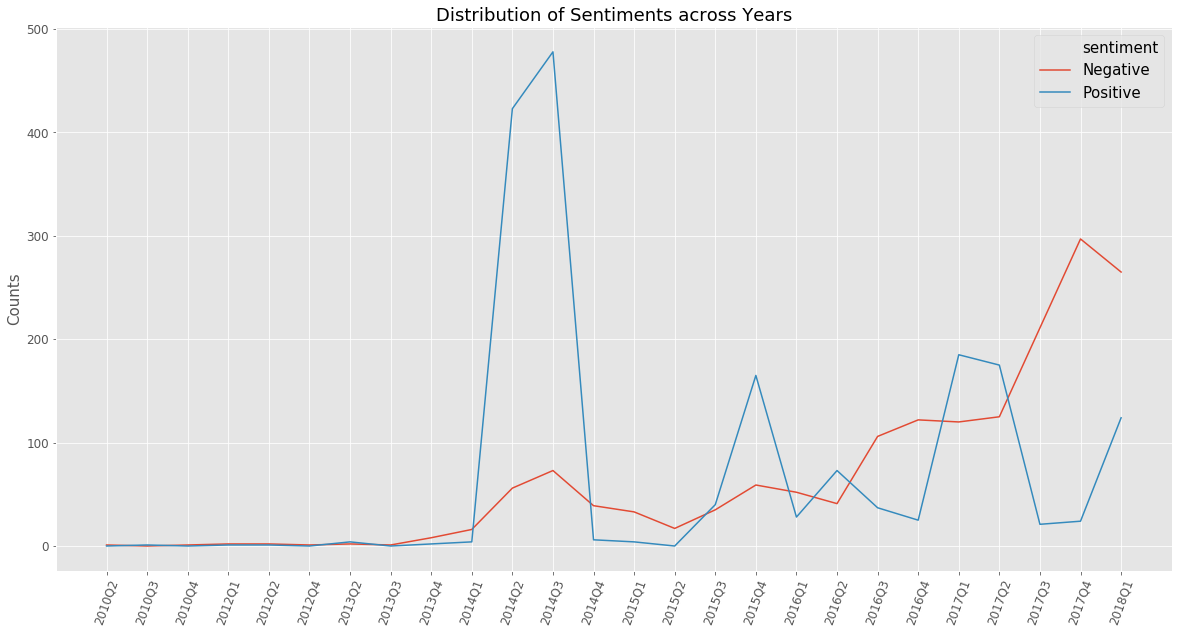

In [12]:
# plotting sentiment distribution across year
fig = plt.figure(figsize=(20, 10))

plt.xticks(rotation=70)
ax = sns.lineplot(x="period", y="value", hue="sentiment", data=sent_year)
ax.set_xlabel('')
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("Distribution of Sentiments across Years", fontsize=18)
ax.legend(prop=dict(size=15))
ax.tick_params(axis='x', which='major', labelsize = 12)
ax.tick_params(axis='y', which='major', labelsize = 12)

As we expected, there was a significant amount of positive reviews back in 2014 and the numbers have been going down.In contrast, the negative reviews are increasing at a high rate, especially during these recent years. 

Note that the low numbers pre-2014 are probably due to the low popularity of the website back then. We also remove quarter 2 of 2018, since the low number is due to the data scraping being performed in early July (First month of quarter 2).

Next, let's see the distribution of topics across the years, both from the negative and positive perspective.

In [13]:
# topics including both positive and negative reviews
topic_year = pd.crosstab(BG_lda['topic'], BG_lda['period'])
topic_year = topic_year.stack().reset_index().rename(columns={0:'value'})
topic_year = topic_year[topic_year['period'] != '2018Q2'] # remove Q2 of 2018

In [14]:
# topics including only positive reviews
BG_lda_pos = BG_lda[BG_lda['sentiment']=='Positive']
topic_year_pos = pd.crosstab(BG_lda_pos['topic'], BG_lda_pos['period'])
topic_year_pos = topic_year_pos.stack().reset_index().rename(columns={0:'value'})
topic_year_pos = topic_year_pos[topic_year_pos['period'] != '2018Q2'] # remove Q2 of 2018

In [15]:
# topics including only negative reviews
BG_lda_neg = BG_lda[BG_lda['sentiment']=='Negative']
topic_year_neg = pd.crosstab(BG_lda_neg['topic'], BG_lda_neg['period'])
topic_year_neg = topic_year_neg.stack().reset_index().rename(columns={0:'value'})
topic_year_neg = topic_year_neg[topic_year_neg['period'] != '2018Q2'] # remove Q2 of 2018

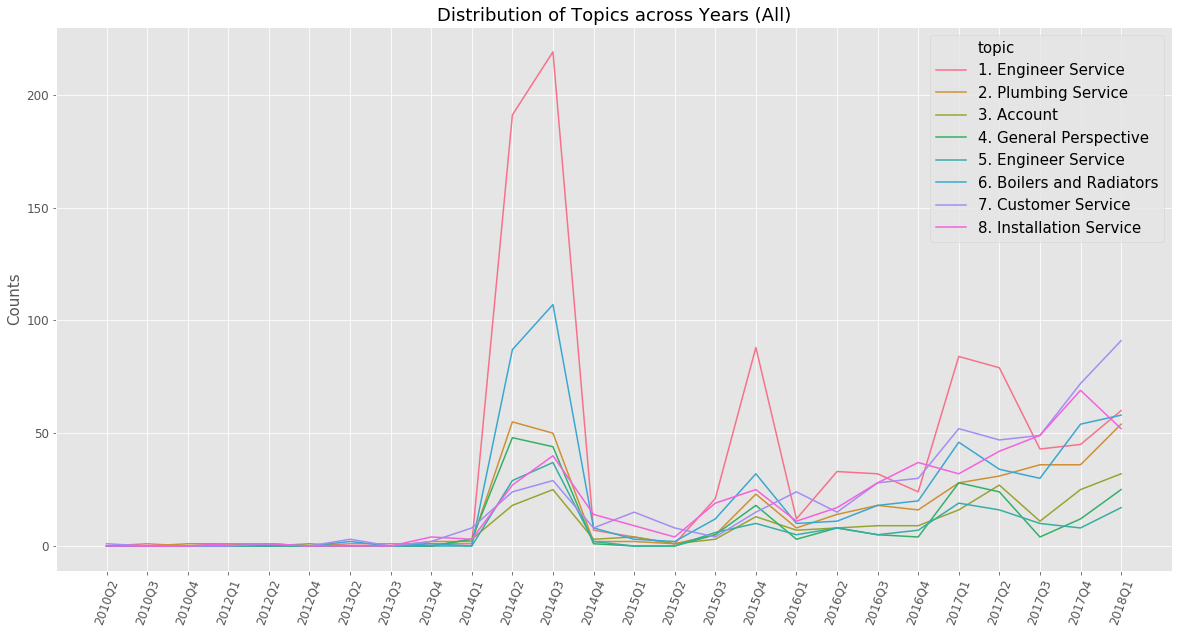

In [16]:
# plotting topic distribution across year
fig = plt.figure(figsize=(20, 10))
plt.xticks(rotation=70)
ax = sns.lineplot(x="period", y="value", hue="topic", data=topic_year)
ax.set_xlabel('')
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("Distribution of Topics across Years (All)", fontsize=18)
ax.legend(prop=dict(size=15))
ax.tick_params(axis='x', which='major', labelsize = 12)
ax.tick_params(axis='y', which='major', labelsize = 12)

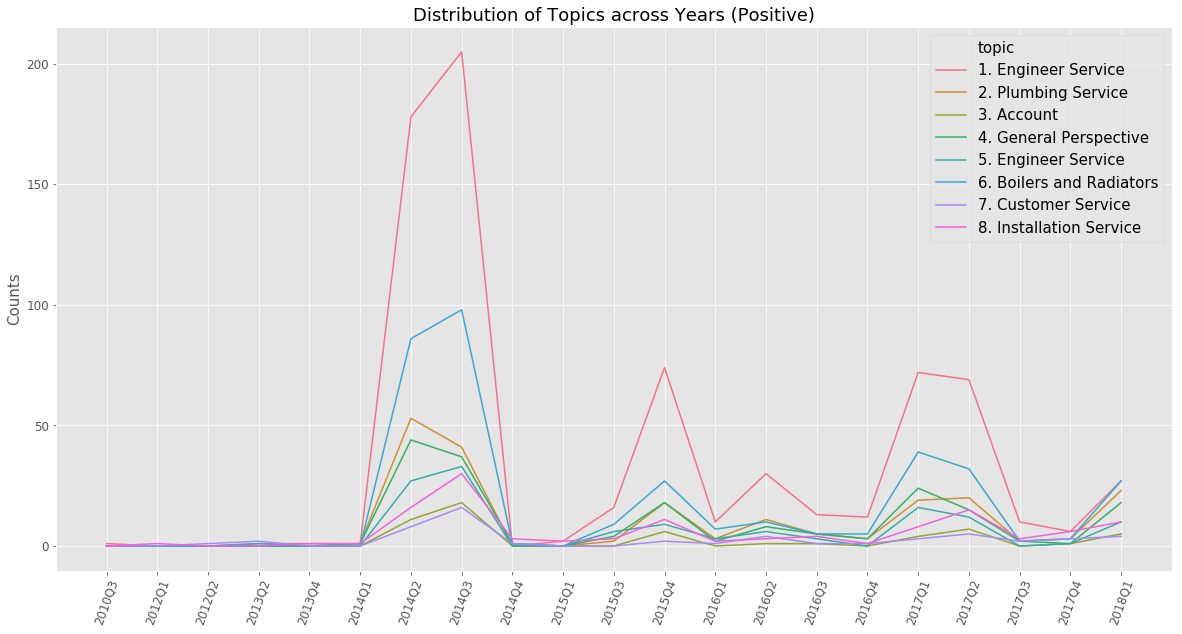

In [17]:
# plotting topic distribution across year (positive)
fig = plt.figure(figsize=(20, 10))
plt.xticks(rotation=70)
ax = sns.lineplot(x="period", y="value", hue="topic", data=topic_year_pos)
ax.set_xlabel('')
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("Distribution of Topics across Years (Positive)", fontsize=18)
ax.legend(prop=dict(size=15))
ax.tick_params(axis='x', which='major', labelsize = 12)
ax.tick_params(axis='y', which='major', labelsize = 12)

The plot confirms our initial guess that topic 1, engineer service has a high count of positive reviews back in 2014. Interestingly, the numbers seem to be decreasing overall, but there are still a decent amount of positive reviews in early 2017. This means that British Gas's engineers are still performing well and this should be continued.

Apart from topic 1, topic 6 also has the same pattern with an overall decreasing positive reviews from 2014 but still decent amounts in early 2017.

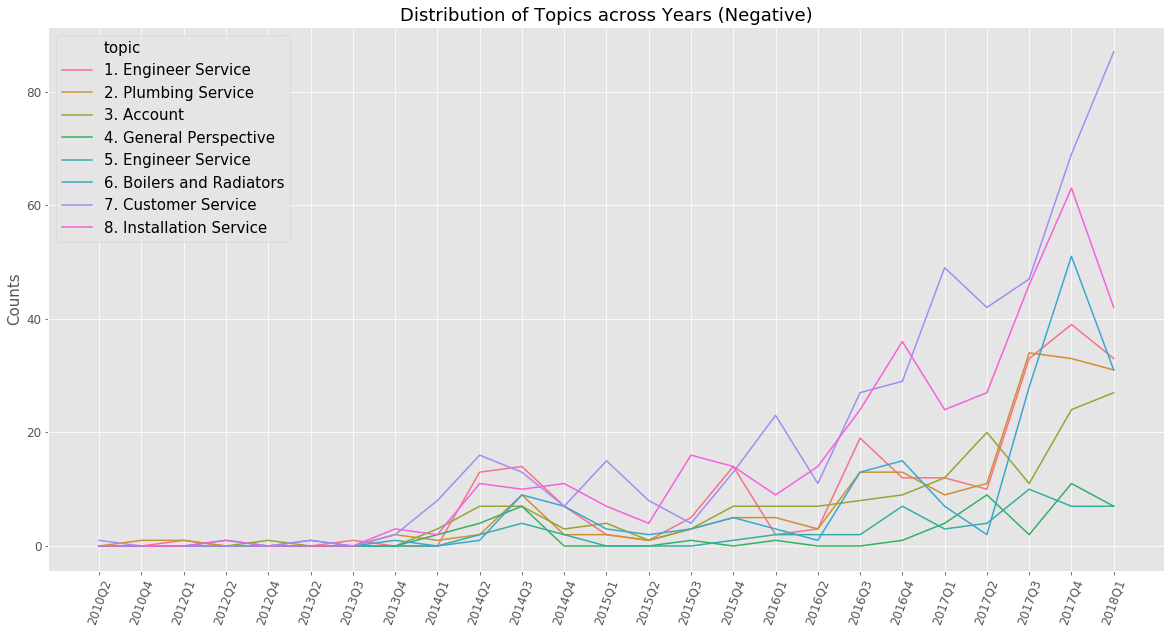

In [18]:
# plotting topic distribution across year (negative)
fig = plt.figure(figsize=(20, 10))
plt.xticks(rotation=70)
ax = sns.lineplot(x="period", y="value", hue="topic", data=topic_year_neg)
ax.set_xlabel('')
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("Distribution of Topics across Years (Negative)", fontsize=18)
ax.legend(prop=dict(size=15))
ax.tick_params(axis='x', which='major', labelsize = 12)
ax.tick_params(axis='y', which='major', labelsize = 12)

As for the negative reviews, it seems that topic 7 and 8 have the highest increasing numbers over the past 3 years. It does seem alarming that customer and installation services are performing this bad. 

However, let's see if we can normalise the figures to account for the overall increase in negative sentiments. The alarming increase might not be due to the two specific topics themselves but rather due to the overall negative reviews.

We normalise it by dividing the number of topics with certain sentiment over the total sentiment counts. We also remove pre-2014 (2013 and before) since the numbers are too low to perform normalisation. 

In [19]:
# normalising the values
s = topic_year_pos.groupby('period')['value'].sum()
s.to_dict()
topic_year_pos2 = topic_year_pos[~topic_year_pos['period'].isin(['2010Q3', '2012Q1', '2012Q2', '2013Q2', '2013Q4'])]
topic_year_pos2['total'] = topic_year_pos2['period'].map(s)
topic_year_pos2['proportion'] = topic_year_pos2['value'].div(topic_year_pos2['total'], axis=0).apply(lambda x: x*100)

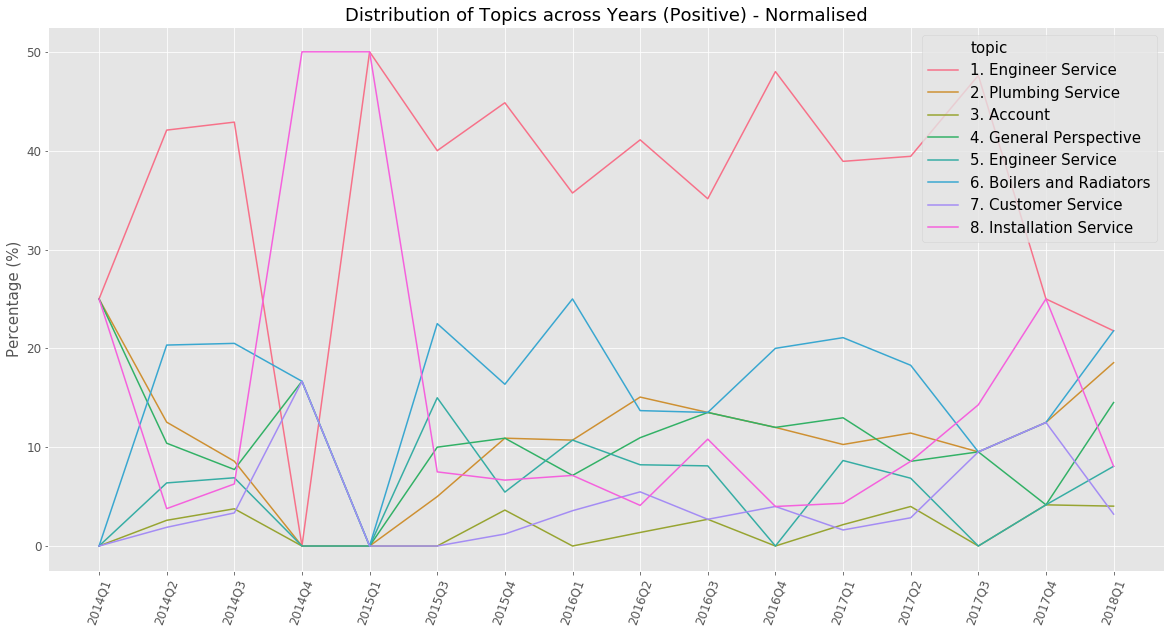

In [20]:
# plotting topic distribution across year (positive) - normalised
fig = plt.figure(figsize=(20, 10))
plt.xticks(rotation=70)
ax = sns.lineplot(x="period", y="proportion", hue="topic", data=topic_year_pos2)
ax.set_xlabel('')
ax.set_ylabel('Percentage (%)', fontsize=15)
ax.set_title("Distribution of Topics across Years (Positive) - Normalised", fontsize=18)
ax.legend(prop=dict(size=15))
ax.tick_params(axis='x', which='major', labelsize = 12)
ax.tick_params(axis='y', which='major', labelsize = 12)

In [21]:
# normalising the values
s2 = topic_year_neg.groupby('period')['value'].sum()
s2.to_dict()
topic_year_neg2 = topic_year_neg[~topic_year_neg['period'].isin(['2010Q2', '2010Q4', '2012Q1', '2012Q2', '2012Q4',
                                                                 '2013Q2', '2013Q3', '2013Q4'])]
topic_year_neg2['total'] = topic_year_neg2['period'].map(s2)
topic_year_neg2['proportion'] = topic_year_neg2['value'].div(topic_year_neg2['total'], axis=0).apply(lambda x: x*100)

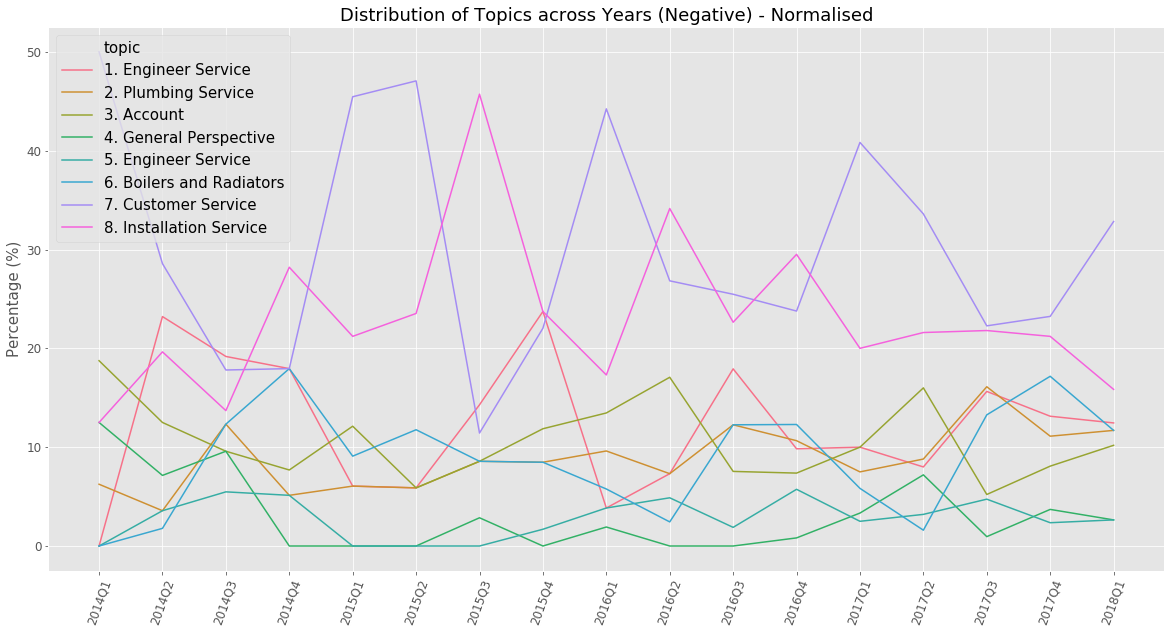

In [22]:
# plotting topic distribution across year (negative) - normalised
fig = plt.figure(figsize=(20, 10))
plt.xticks(rotation=70)
ax = sns.lineplot(x="period", y="proportion", hue="topic", data=topic_year_neg2)
ax.set_xlabel('')
ax.set_ylabel('Percentage (%)', fontsize=15)
ax.set_title("Distribution of Topics across Years (Negative) - Normalised", fontsize=18)
ax.legend(prop=dict(size=15))
ax.tick_params(axis='x', which='major', labelsize = 12)
ax.tick_params(axis='y', which='major', labelsize = 12)

Both of these normalised graphs tell a different story from the previous graphs. Several comments that can be made:

Positive: 
* The normalised graph shows that topic 1 engineer service has always had the same proportion throughout the years even if the numbers seem higher in 2014 in the non-normalised version. This means that the engineer service's quality stays the same throughout the years and doesn't deteriorate.
* What's surprising is topic 8 installation service had a really high positive proportion in 2014 and has since gone down.

Negative:
* Even though topic 7 and 8 seem like increasing a lot over the past few years, from the normalised graph, we can see that its proportion is actually quite constant throughout the years. The same can be said to the other topics. This means that the same problems have exist since 2014. Its the overall numbers that keeps on increasing. However, this doesn't mean that we are fine with these two areas (customer service & installation service) since they still occupy the highest proportion amont the negative topics.

Let's try to understand the main problems that exists within these negative topics. We look at the top 5 most representative reviews of the two topics by finding the ones with the highest probability of being within those topics.

In [23]:
# sorting topic 7 based on the probability and selecting short reviews
topic_7 = BG_lda[BG_lda['topic']=='7. Customer Service']
topic_7 = topic_7.sort_values(by=['prob of topic #'], ascending=False)
topic_7 = topic_7[topic_7['tokens'].map(len) < 100]
topic_7.head()

,rating,reviews,date,sentiment,tokens,prob of topic #,topic,fy,quarter,period
977,1,A complete Joke of a company. Brit...,2017-09-18,Negative,"[complete, joke, company, british_gas, make, s...",0.991841,7. Customer Service,2017,Q2,2017Q2
2369,1,I have never taken to this method ...,2015-06-08,Negative,"[never, take, method, complaint, not, see, way...",0.991667,7. Customer Service,2015,Q1,2015Q1
2014,1,I am one of the British Gas Busine...,2016-05-11,Negative,"[one, british_gas, business, customer, use, br...",0.990977,7. Customer Service,2016,Q1,2016Q1
2030,1,Since buying my house in 2013 I ha...,2016-04-21,Negative,"[since, buying, house, 2013, british_gas, ener...",0.990651,7. Customer Service,2016,Q1,2016Q1
1009,1,Had an estimated bill produced whi...,2017-08-29,Negative,"[estimate_bill, produce, know, wrong, boiler, ...",0.990415,7. Customer Service,2017,Q2,2017Q2


In [24]:
print(topic_7['reviews'][2369])

            I have never taken to this method of complaint, but cannot see any other way to get a response so that my issues are resolved.I am a loyal customer of BG - this loyalty clearly is only one way given recent events.  Having move house recently, we also migrated across to BG as felt this was the right and easiest thing to do given that there have never been any issues to speak of in the past.  The new house it turns out seems to loose energy and whilst we partly accept this due to single glazed windows, I really struggled to understand how our bills have been calculated given that our costs are now 3 times more than when we moved in 6 month earlier. After numerous emails and calls, we were offered and agreed to move to a different tariff to assist with this increase to our bill and have been waiting for this now since the end of March.  I am so disappointed and feel that we cannot move as now we are in debit due to this hike in price.  A really would not advise anyone to go to

From this significant review for topic 7, it seems that the problem here is the issues that customers are facing with their bill calculation. In addition to that, the customer's feeling of being unappreciated is made worse by the lack of professional and helpful assistance from the call centres.

In [25]:
print(topic_7['reviews'][977])

            A complete Joke of a company. British Gas make me sick. When i moved into my property they wrote to me and said i was on their standard tariff i called them and they told me they would ring back with details of better tariffs they never did.. They sent a bill for £129 and i called them they said it was accurate i disagreed but they would not listen. They then told me they can transfer me to a better tariff i told them not to bother as i was leaving them which i did. They then wrote to me and informed me i would get a final bill after my gas was taken over they sent me a bill it was a further 13 days before my new supplier took over my electricity i then got a bill from British Gas for £79.13 this was for 13 days use of electricity. I have refused to pay this in the 13 days they scammed me for i was home for 3 days every item apart from my fridge was off so i really would like to know where they got this figure from. They make threats but i would love them to pay me a visit 

Again, the same problem occurs with the final bill when a customer decides to leave British Gas.

Let's take a look at one of topic 8 installation service's significant review to have an idea what the problems are in that regard.

In [26]:
topic_8 = BG_lda[BG_lda['topic']=='8. Installation Service']
topic_8 = topic_8.sort_values(by=['prob of topic #'], ascending=False)
topic_8 = topic_8[topic_8['tokens'].map(len) < 100]
topic_8.head()

,rating,reviews,date,sentiment,tokens,prob of topic #,topic,fy,quarter,period
546,1,We have a Homecare 400 policy and ...,2018-03-01,Negative,"[homecare_400, policy, british_gas, shock, val...",0.991642,8. Installation Service,2017,Q4,2017Q4
180,1,Customer of BG for some 15 years ...,2018-05-08,Negative,"[customer, bg, 15_year, move_new, home, part, ...",0.991234,8. Installation Service,2018,Q1,2018Q1
2308,1,I had a new boiler installed just ...,2015-12-10,Negative,"[new_boiler, instal, over, year_ago, s, under,...",0.990815,8. Installation Service,2015,Q3,2015Q3
767,5,I don't normally do reviews but af...,2017-12-12,Positive,"[n't, normally, review, see, many, negative, r...",0.990814,8. Installation Service,2017,Q3,2017Q3
2404,2,Before I start I would just like t...,2015-03-19,Negative,"[start, would_like, say, not, bad, review1, cu...",0.990583,8. Installation Service,2014,Q4,2014Q4


In [27]:
print(topic_8['reviews'][2308])

            I had a new boiler installed just over a year ago and it's under warranty for 5 years and thought I would sign up to BG Homecare to service my boiler and cover any repair issues for peace of mind. Having signed up online, i Booked the initial engineer visit and was amazed to learn after 10 minutes that my boiler would not be covered as it was not on the list of boiler models. Wow! I was looking to spend over £200 / year and had waited in all day for my first visit to learn that my fully working and 1 year old boiler would not be covered. I rang BG and they simply cancelled my policy.I will be using a local plumber to service my boiler and will not waste spending a premium on such a nonsensical attitude to customers. The reviews on this site are pretty bad. The engineer who visited was very nice and he seemed embarrassed by the whole episode. But it's quite common apparently.Ho humm!
        


It seems that topic 8 revolves more around the problems that occur during boiler installations, which is similar to the word cloud generated in lda.ipynb for topic 8. Infact, it would be better to use the word clouds generated by the lda and refer to the plots above for the topic's sentiment to have a general idea of where the strength and weakness lie.

We can also try to color code the tokens in a review that are being used by our model. First, let's reload the model back and then use the color_words function to color them. Let's try to color review 2369 which belonged to topic 7.

In [28]:
# turning tokens into color based on their topic probability [Adapted from https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb]
def color_words(model, doc):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    # make into bag of words
    doc = model.id2word.doc2bow(doc)
    # get word_topics
    doc_topics, word_topics, phi_values = model.get_document_topics(doc, per_word_topics=True)

    # color-topic matching
    topic_colors = { 0:'cyan', 1:'indigo', 2:'blue', 3:'grey', 4:'green', 5:'brown', 6:'coral', 7:'red' }
    
    cyan_patch = patches.Patch(color='cyan', label='1. Engineer Service') 
    indigo_patch = patches.Patch(color='indigo', label='2. Plumbing Service"')
    blue_patch   = patches.Patch(color='blue',   label='3. Account')
    grey_patch   = patches.Patch(color='grey',   label='4. General Perspective')
    green_patch  = patches.Patch(color='green',  label='5. Engineer Service')
    brown_patch = patches.Patch(color='brown', label='6. Boilers and Radiators')
    coral_patch = patches.Patch(color='coral', label='7. Customer Service')
    red_patch    = patches.Patch(color='red',    label='8. Installation Service')
    
    # set up fig to plot
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    t = plt.gca().transData

    # a sort of hack to make sure the words are well spaced out. our max token number is 100.
    token_range = [(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 70), (71, 80), (81, 90), (91, 100)]
    vert_pos = 1
    
    # use matplotlib to plot words
    for i, j in token_range:
        for word, topics in word_topics[i:j]:
            text = plt.text(0, vert_pos, " "+model.id2word[word]+" ",
                   transform=t, fontsize=20, color=topic_colors[topics[0]])
            text.draw(fig.canvas.get_renderer())
            ex = text.get_window_extent()
            t = transforms.offset_copy(text._transform, x=ex.width, units='dots')
        vert_pos -= 0.1
        t = plt.gca().transData

    ax.set_axis_off()
    ax.legend(handles=[cyan_patch, indigo_patch, blue_patch, grey_patch, green_patch, brown_patch, coral_patch, red_patch],
              bbox_to_anchor=(0, 1))
    plt.show()

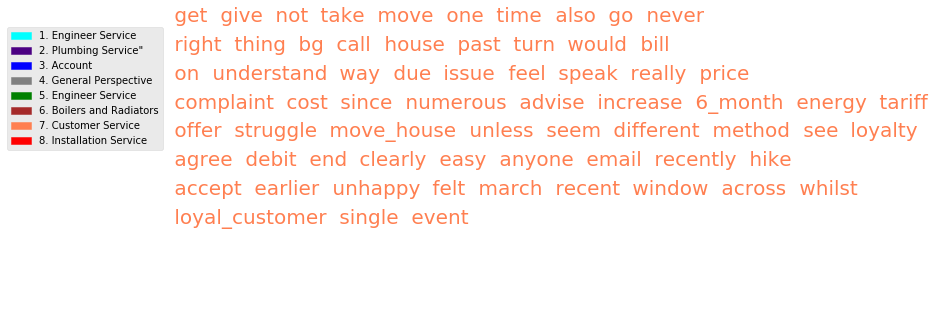

In [29]:
# loading back our optimal model
opt_model = LdaModel.load('BG_lda.model')

doc = BG_lda['tokens'][2369]
color_words(opt_model, doc)

All of the words are assigned to topic 7. This is understandable since the probability of the document being in topic 7 is really high (>99%). Let's try to find a review that has a low probability of being in a certain topic.

In [30]:
# let's try to find a review that does not have a high probability (so more topics can be identified from the words)
BG_lda[(BG_lda['prob of topic #'] <= 0.3) & (BG_lda['prob of topic #'] > 0.29)]

,rating,reviews,date,sentiment,tokens,prob of topic #,topic,fy,quarter,period
1577,2,So when we move to our new home we...,2017-03-24,Negative,"[move_new, home, choose, britishgas, offer, on...",0.296905,6. Boilers and Radiators,2016,Q4,2016Q4


Let's try to view and then color document 1577. The probability of it being topic 6 is only 29.7% (highest). Therefore, there should be a mixture of topics within the document.

In [31]:
# view the actual review
rev = BG_lda['reviews'][1577]
print(rev)

            So when we move to our new home we choose BritishGas because they have this offer online:"Free electricity Every Saturday or Sunday from 9am–5pm with one of our new smart meter FreeTime"We move on last October and since then have been a nightmare to have this service active at our home, first the system online don't realise that we are requesting service for a new home and just spend weeks without nothing happen or even a single contact from BGas side.Today I receive the visit of another Service Engineer and guess what... Once again it wasn't possible to have the smart meter fitted and this time the excuse was something about the electrical device that is outside is not able to link with the home device or something like that?!Now I'm waiting for another call to book another day just to do this, hope soon.To be honest thing very well when you need to choose this kind of service and ask for another company's as well for quotes,Not happy in the end!
        


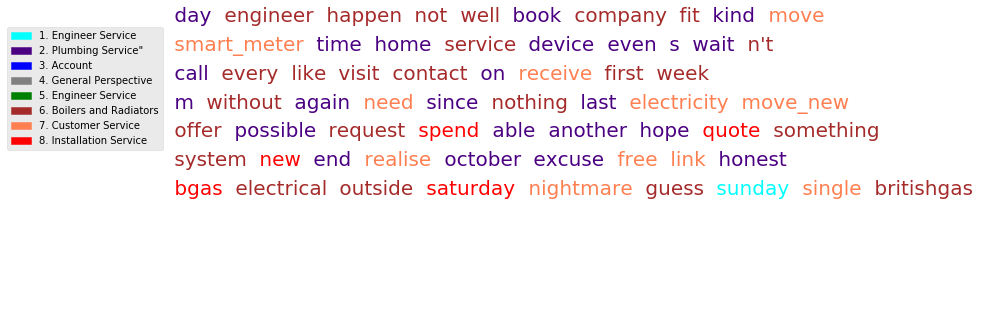

In [32]:
# select the document and color it
doc2 = BG_lda['tokens'][1577]
color_words(opt_model, doc2)

From the colors of the words, it does seem that most of them are brown i.e. categorised as topic 6. However, the topics are not clear cut, evidenced by the mixtures of other colors.

### Final thoughts

By combining the LDA and sentiment analysis techniques, we can have a general understanding of what the customers like and what they hate. LDA provides us with the topics and by analysing it from a sentiment analysis perspective, we can know whether the topics are positive or negative. For example, by referring to the word cloud generated in lda.ipynb and the barplots above, we know that topic 7 revolves around unsolved bills (most frequent word in topic 7) where the customer tries to get help from the customer service to resolve the issue but they were not satisfied with the treatment that they received.

Sentiment classification by using Naive Bayes that was performed earlier also provided us with good insights. However, LDA seems to provide much more instead of only a general view of the positive and negative words given by the classification.